# Evaluation for face recognition system

In [1]:
from face_recognition import FaceRecognition
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
app = FaceRecognition()
app.prepare(ctx_id=0, det_size=(640, 640))
app.read_facebase("./img/targets")

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'cudnn_conv_algo_search': 'EXHAUSTIVE', 'do_copy_in_default_stream': '1', 'arena_extend_strategy': 'kNextPowerOfTwo', 'gpu_external_free': '0', 'gpu_external_alloc': '0', 'gpu_mem_limit': '18446744073709551615', 'device_id': '0'}}
find model: /home/geez0219/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'cudnn_conv_algo_search': 'EXHAUSTIVE', 'do_copy_in_default_stream': '1', 'arena_extend_strategy': 'kNextPowerOfTwo', 'gpu_external_free': '0', 'gpu_external_alloc': '0', 'gpu_mem_limit': '18446744073709551615', 'device_id': '0'}}
find model: /home/geez0219/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExec

## Visualize features distribtion

In [38]:
target_path = "./img/targets"
target_embedding = {}
PCA_pool = []

# collect target embeddings
for name in os.listdir(target_path):
    tmp = []
    for file in os.scandir(os.path.join(target_path, name)):
        if file.is_file():
            img = cv2.imread(file.path)
            features = app.get_single_features(img)
            tmp.append(features)
            PCA_pool.append(features)
    target_embedding[name] = tmp

In [39]:
from sklearn.decomposition import PCA
from matplotlib.pyplot import cm
pca = PCA(n_components=2)
pca.fit(PCA_pool)

PCA(n_components=2)

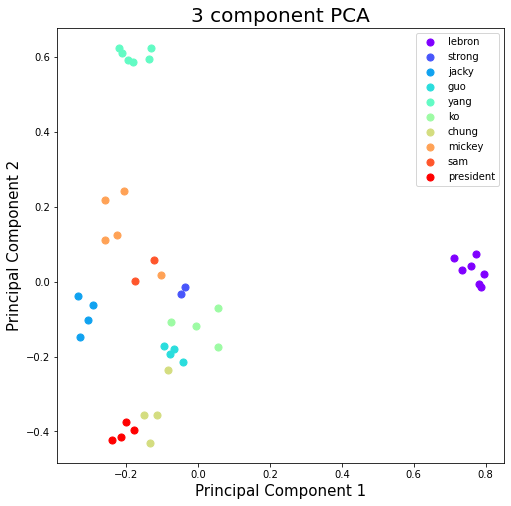

In [40]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
labels = list(target_embedding.keys())
colors = cm.rainbow(np.linspace(0, 1, 10))

for i, label in enumerate(labels):
    after_pca = pca.transform(target_embedding[label])
    ax.scatter(after_pca[:,0],
               after_pca[:,1],
               color = colors[i], 
               s = 50)
ax.legend(labels)

Since data points are well clusted in PCA figure, we know the face regonition model works.

## Test
We are going to test the face recognition algorithm with dataset that have images of 10 people (5 in the target groups, the others are not). The testing images are completely different from training set. The testing task is to classify **whether the face in the image is in the target group or not**.

We are going to plot the ROC curve of precision and recall, and thus determine the optimal threshold. 

In [3]:
test_path = "./img/test"
test_embedding = {}

for name in os.listdir(test_path):
    tmp = []
    for file in os.scandir(os.path.join(test_path, name)):
        if file.is_file():
            img = cv2.imread(file.path)
            tmp.append(app.get_single_features(img))
    test_embedding[name] = tmp

In [4]:
def get_group_state(threshold, test_embedding, app):
    TP, FP, FN, TN = 0, 0, 0, 0
    for label, vecs in test_embedding.items():
        for vec in vecs:
            if vec is None:
                continue
            predicted = app.classify(vec, threshold)
            if not label.startswith("other") and predicted != "other":
                TP += 1
            elif label.startswith("other") and predicted != "other":
                FP += 1
            elif not label.startswith("other") and predicted == "other":
                FN += 1
            else:
                TN += 1
    return TP, FP, FN, TN

In [5]:
def plot_ROC_curve(test_embedding, app, points=100):
    thresholds = np.linspace(0, 1, points)
    
    precisions = []
    recalls = []
    t_pre = []
    t_rec = []
    for t in thresholds:
        TP, FP, FN, TN = get_group_state(t, test_embedding, app)
        if (TP + FP) != 0:
            precisions.append(TP / (TP + FP))
            t_pre.append(t)
        if (TP + FN) != 0:
            recalls.append(TP / (TP + FN))
            t_rec.append(t)
        
    fig, ax = plt.subplots()

    # Using set_dashes() to modify dashing of an existing line
    line1, = ax.plot(t_pre, precisions, label='precision')
    line1.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break

    # Using plot(..., dashes=...) to set the dashing when creating a line
    line2, = ax.plot(t_rec, recalls, label='recall')

    ax.legend()
    plt.show()

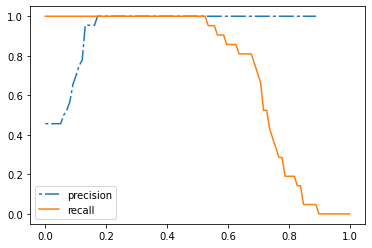

In [6]:
plot_ROC_curve(test_embedding, app, points=100)

## Conclusion
According to the ROC figure, we can see thereshold around 0.2~0.5 will yield the perfect precision and recall rate. Therefore the middle value 0.35 should be the optimal threshold.